# Cartpole in IBM FL using RLlib

## Outline:
- [Add conda environment to Jupyter Notebook](#setup)
- [Federated Learning(FL), Reinforcement Learning(RL), and FL-RL](#intro)
- [Cartpole Problem](#cartpole)
- [Aggregator](#Aggregator)
    - [Aggregator Configuration](#Aggregator-Configuration)
    - [Running the Aggregator](#Running-the-Aggregator)
- [Parties](#Parties)
    - [Party Configuration](#Party-Configuration)
    - [Running the Parties](#Running-the-Parties)
- [Training and Evaluation](#Training-and-Evaluation)
- [Visualize Results](#Visualize-Results)
- [Shut Down](#Shut-Down)

## Add conda environment to Jupyter Notebook <a name="setup"></a>

Please ensure that you have activated the `conda` environment following the instructions in the project README.

Once done, run the following commands in your terminal to install your conda environment into the Jupyter Notebook:

1. Once you have activated the conda environment, install the `ipykernel` package: `conda install -c anaconda ipykernel`

2. Next, install the `ipykernel` module within Jupyter Notebook: `python -m ipykernel install --user --name=<conda_env>`

3. Setup PYTHONPATH variable so `Ray` workers can find required modules: `export PYTHONPATH=<project_path>`, where `project_path` is the directory where the IBMFL repository was cloned.

4. Finally, restart the jupyter notebook once done. Ensure that you are running this Notebook from `<project_path>/Notebooks`.

When the Notebook is up and running it may prompt you to choose the kernel. Use the drop down to choose the kernel name same as that chosen when running `conda activate <conda_env>`. If no prompt shows up, you can change the kernel by clicking _Kernel_ > _Change kernel_ > _`<conda_env>`_.

## Federated Learning (FL), Reinforcement Learning (RL) and FL-RL <a name="intro"></a>

**Federated Learning (FL)** is a distributed machine learning process in which each participant node (or party) retains their data locally and interacts with  other participants via a learning protocol. 
One main driver behind FL is the need to not share data with others  due to privacy and confidentially concerns.
Another driver is to improve the speed of training a machine learning model by leveraging other participants' training processes.

Setting up such a federated learning system requires setting up a communication infrastructure, converting machine learning algorithms to federated settings and in some cases knowing about the intricacies of security and privacy enabling techniques such as differential privacy and multi-party computation. 

**Reinforcement Learning (RL)** is an area of machine learning aimed at making decisions while maximizing rewards. It differs from supervised machine learning techniques in the sense that the learner isn't told which actions to take for maximizing reward. Instead it must *discover* which actions yield the most reward *by trying* them.

**FL-RL**

There are several use cases where both RL and FL can be combined, such as online portfolio optimization, robot navigation, logistics or supply chain optimizations -- essentially any RL problem could typically benefit from the distributed benefits of FL as listed earlier.

In this Notebook we use [IBM FL](https://github.com/IBM/federated-learning-lib) along with [RLLib](https://docs.ray.io/en/master/rllib.html) to have multiple parties train a self-learning agent, in this case, the Cartpole problem. For a more technical dive into IBM FL, refer the whitepaper [here](https://arxiv.org/pdf/2007.10987.pdf).

In the following cells, we set up each of the components of a Federated Learning network (See Figure below) wherein all involved parties aid in training their respective local cartpoles to arrive at the upright pendulum state. In this notebook we default to 5 parties, but depending on your resources you may use fewer parties.



<img src="../images/FL_Network.png" width="720"/>
<figcaption><center>Modified from Image Source: <a href="https://arxiv.org/pdf/2007.10987.pdf">IBM Federated Learning: An Enterprise FrameworkWhite Paper V0.1</a></center></figcaption>


## Cartpole Problem <a name="cartpole"></a>

Also known as [inverted pendulum](https://en.wikipedia.org/wiki/Inverted_pendulum#Inverted_pendulum_on_a_cart), the cartpole is essentially a pendulum attached to a cart, with its center of mass above its pivot point. As the pendulum would be unstable, the cart moves along a frictionless track, to keep the pole upright. 

<img src="../images/cartpole.gif" width="512"/>
<figcaption><center>Image Source: <a href="https://gym.openai.com/envs/CartPole-v1/">Open AI gym</a></center></figcaption>

For more details on the problem within the Reinforcement Learning context, refer Open AI gym [here](https://gym.openai.com/envs/CartPole-v1/).

For simplification, let the system be controlled by applying a force of +1 or -1 to the cart. 

The pendulum starts upright, and the goal is to prevent it from falling over. So, a **reward** of +1 is provided for every timestep that the pole remains upright. 

The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

## Aggregator

coordinates the overall process, communicates with the parties and integrates the results of the training process. This integration of results is done using the _Fusion Algorithm_.

A fusion algorithm queries the registered parties to carry out the federated learning process. The queries sent vary according to the model/algorithm type.  In return, parties send their reply as a model update object, and these model updates are then aggregated according to the specified Fusion Algorithm, specified via a `Fusion Handler` class. 

To take a look at the supported fusion algorithms, refer the IBM FL tutorial page [here](https://github.com/IBM/federated-learning-lib/blob/main/README.md#supported-functionality).

### Aggregator Configuration

We discuss the various configuration parameters for the Aggregator here.

Given below is an example of the aggregator's configuration file. In this example, the aggregator does not specify a data file or maintain a global model. Hence, during the federated learning process, it only keeps track of the current model parameters. 

However, it is possible that the aggregator also has data for testing purposes and maintains a global model. When this is the case, one needs to add `data` and `model` sections in the configuration file.

<img src="../images/arch_aggregator.png" width="680"/>
<figcaption><center>Image Source: <a href="https://arxiv.org/pdf/2007.10987.pdf">IBM Federated Learning: An Enterprise FrameworkWhite Paper V0.1</a></center></figcaption>

#### Building blocks in the configuration file:

- `connection` (also used in Party config): needed to initiate the connection; includes server information (`info`, optional, depends on the connection type), a connection class name, a connection file location, and a synchronization mode flag (`sync`) for training phase

- `fusion`: needed to initiate a fusion algorithm at the aggregator side; includes a fusion handler class name and a fusion handler file location

- `protocol_handler`: needed to initiate a protocol; includes a protocol handler class name and a protocol handler file location;

- `hyperparams`: includes global training and local training hyperparameters, including `termination_accuracy`, learning rate (`lr`), `optimizer`, etc., depending on the model being used.

For detailed documentation of the objects described below, refer the API docs [here](https://ibmfl.mybluemix.net/api-documentation).

In [1]:
agg_config = {
    'connection': {
        'info': {
            'ip': '127.0.0.1',
            'port': 8000
        },
        'name': 'FlaskConnection',
        'path': 'ibmfl.connection.flask_connection',
        'sync': False
    },

    'fusion': {
        'name': 'RLFusionHandler',
        'path': 'ibmfl.aggregator.fusion.rl_avg_fusion_handler'
    },

    # Protocol handler controls overall Federated Learning algorithm such as plain FL, homomorphic encryption, 
    # Hybrid-one etc
    'protocol_handler': {
        'name': 'ProtoHandler',
        'path': 'ibmfl.aggregator.protohandler.proto_handler'

    },

    'hyperparams': {
        'global': {
            'rounds': 15,
            'num_parties': 4
        }
    }
}


### Running the Aggregator
Next we pass the configuration parameters set in the previous cell to instantiate the `Aggregator` object. Finally, we `start()` the Aggregator process.

In [2]:
import sys  
sys.path.append("../..")
import os
os.chdir("../..")
from ibmfl.aggregator.aggregator import Aggregator
aggregator = Aggregator(config_dict=agg_config)
aggregator.start()

2020-10-06 02:56:15,233 -STD ibmfl.util.config - INFO - Getting Aggregator details from arguments.
2020-10-06 02:56:15,234 -STD ibmfl.util.config - INFO - No data config provided for this setup.
2020-10-06 02:56:15,236 -STD ibmfl.util.config - INFO - No model config provided for this setup.
2020-10-06 02:56:15,818 -STD ibmfl.util.config - INFO - No local training config provided for this setup.
2020-10-06 02:56:15,820 -STD ibmfl.connection.flask_connection - INFO - RestSender initialized
2020-10-06 02:56:15,822 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.START
2020-10-06 02:56:15,825 -STD ibmfl.connection.flask_connection - INFO - Receiver Initialized
2020-10-06 02:56:15,834 -STD ibmfl.connection.flask_connection - INFO - Initializing Flask application
2020-10-06 02:56:15,848 -STD ibmfl.aggregator.aggregator - INFO - Aggregator initialization successful
2020-10-06 02:56:15,851 -STD ibmfl.aggregator.aggregator - INFO - Aggregator start successful
 * Serving F

## Parties

Each party holds its own dataset that is kept to itself and used to answer queries received from the aggregator. Because each party may have stored data in different formats, FL offers an abstraction called Data Handler. This module allows for custom implementations to retrieve the data from each of the participating parties. A local training handler sits at each party to control the local training happening at the party side. 

<img src="../images/arch_party.png" width="680"/>
<figcaption><center>Image Source: <a href="https://arxiv.org/pdf/2007.10987.pdf">IBM Federated Learning: An Enterprise FrameworkWhite Paper V0.1</a></center></figcaption>

### Party Configuration
In the following cell, we setup configurations for parties, including network-level details, hyperparameters as well as the model specifications. 

The `get_hyperparams` method enumerates all the hyperparameters such as the `checkpoint frequency`, `iterations`, and `learning rate (lr)` among others for the training phase as well as the `steps` for the evaluation phase. The parameters such as `eager` and `checkpoint_frequency` are specific to the chosen model, i.e., the `RLlibFLModel` class, in this case. 

Note that while the `default` hyperparameters (a Python dictionary) suffice for the experiment, users may also add hyperparameter dictionaries, following the example given in `party_hyperparams[1]`. When such additional hyperparameters are given, the method returns an updated copy of the `default` hyperparameter dictionary to include (or overwrite with) the new values.

#### Building blocks in the configuration file

Finally, we configure party specific configurations in the `get_party_config` method, which specifies model related configurations as well as other parameters necessary for the federated learning setup. These model related configurations are identical to those generated (yaml files) during the terminal run. 

- `local_training`: handles the train and eval commands, also initializes data, environment and models

- `protocol_handler`: party protocol handler communicates with the Aggregator, bridging between Aggregator and local training handler

- `aggregator`: IP and port at which the Aggregator is running, so the party may conntect to it

- `connection`: networking details for the party, same as that described for aggregator above

- `data`: information needed to initiate a data handler class; includes a given data path, a data handler class name, and a data handler file location

- `model`: details about the model, including `name`, the model class file location, i.e., `path`, and the given model specification path, i.e., `spec`. In this example, we use the Proximal Policy Optimizer (PPO) algorithm, as indicated under the `spec`.

**Note**: in a typical FL setting, the parties may have very different configurations from each other. However, in this simplified example, the config does not differ much across parties. Also, as of this release all parties registered with the aggregator participate in the training. Dynamically letting registered parties to skip training in certain rounds may be supported in subsequent versions.

In [3]:
def get_hyperparams(party_id):
    party_hyperparams = {}
    default = {
        'training': {
            'run_config': {
                'iterations': 1,
                'checkpoint_frequency': 1
            },
            'model_config': {
                'lr': 0.0005,
                'num_gpus': 0,
                'num_workers': 1,
                'eager': False
            }
        },
        'evaluation': {
            'run_config': {
                'steps': 10000
            }
        }
    }
    party_hyperparams[1] = {
        'evaluation': {
            'run_config': {
                'steps': 5000
            }
        }
    }
    default.update(party_hyperparams.get(party_id) or dict())
    return default


def get_party_config(party_id):
    party_config = {
        'local_training': {
            'name': 'RLLocalTrainingHandler',
            'path': 'ibmfl.party.training.rl_local_training_handler'
        },

        # party protocol handler receives all the request from aggregator and route it to respective methods in local training handler
        'protocol_handler': {
            'name': 'PartyProtocolHandler',
            'path': 'ibmfl.party.party_protocol_handler'

        },

        # port at which the aggregator is running so that the party can establish a connection
        'aggregator': {

            'ip': '127.0.0.1',
            'port': 8000

        },
        'connection': {
            'info': {
                'ip': '127.0.0.1',
                'port': 8085 + party_id,
                'id': 'party' + str(party_id)
            },
            'name': 'FlaskConnection',
            'path': 'ibmfl.connection.flask_connection',
            'sync': False
        },

        # in cartpole case, the openai gym environment will act as the data for fl
        'data': {
            'info': {
                'env_spec': {
                    'env_definition': 'ibmfl.util.data_handlers.cartpole_env',
                    'env_name': 'CartPoleEnv'
                }
            },
            'name': 'CartpoleEnvDataHandler',
            'path': 'ibmfl.util.data_handlers.cartpole_env_data_handler'
        },

        'model': {
            'name': 'RLlibFLModel',
            'path': 'ibmfl.model.rllib_fl_model',
            'spec': {
                'policy_definition': 'PPO',
                'policy_name': 'cartpole-ppo',
                'params': get_hyperparams(party_id)
            }
        }
    }
    return party_config


 * Debug mode: off
2020-10-06 02:56:15,935 -STD werkzeug - INFO -  * Running on http://127.0.0.1:8000/ (Press CTRL+C to quit)


### Running the Parties

Now, we invoke the `get_party_config` function to setup each of the parties and `start()` them up.

Finally, we register the party with the Aggregator.

Note that we maintain a `partyList` to allow for a seamless shutdown in the end.

In [4]:
num_parties = agg_config['hyperparams']['global']['num_parties']
from ibmfl.party.party import Party
partyList = []
for party_id in range(num_parties):
  party_config = get_party_config(party_id)
  party = Party(config_dict=party_config)
  party.start()  
  party.register_party()
  partyList.append(party)

2020-10-06 02:56:15,971 -STD ibmfl.util.config - INFO - Getting Aggregator details from arguments.


/opt/anaconda3/envs/EXTERNAL_MAIN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/EXTERNAL_MAIN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/EXTERNAL_MAIN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/EXTERNAL_MAIN/lib/python3.6/s

2020-10-06 02:56:21,907 -STD ibmfl.util.config - INFO - No fusion config provided for this setup.
2020-10-06 02:56:21,924 -STD ibmfl.connection.flask_connection - INFO - RestSender initialized


/opt/anaconda3/envs/EXTERNAL_MAIN/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/opt/anaconda3/envs/EXTERNAL_MAIN/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


(pid=652) /opt/anaconda3/envs/EXTERNAL_MAIN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=652)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=652) /opt/anaconda3/envs/EXTERNAL_MAIN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=652)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=652) /opt/anaconda3/envs/EXTERNAL_MAIN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=652)   _np_qint16 = np.dtype([("qint16", np.i

2020-10-06 02:56:48,050 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 02:56:48] "POST /6 HTTP/1.1" 200 -
2020-10-06 02:56:48,060 -STD ibmfl.party.party - INFO - Registration Successful
2020-10-06 02:56:48,094 -STD ibmfl.util.config - INFO - Getting Aggregator details from arguments.
2020-10-06 02:56:48,101 -STD ibmfl.util.config - INFO - No fusion config provided for this setup.
2020-10-06 02:56:48,113 -STD ibmfl.connection.flask_connection - INFO - RestSender initialized
(pid=648) /opt/anaconda3/envs/EXTERNAL_MAIN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=648)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=648) /opt/anaconda3/envs/EXTERNAL_MAIN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is d

 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
2020-10-06 02:57:07,384 -STD werkzeug - INFO -  * Running on http://127.0.0.1:8088/ (Press CTRL+C to quit)
2020-10-06 02:57:07,398 -STD ibmfl.party.party - INFO - Registering party...
2020-10-06 02:57:07,428 -STD ibmfl.connection.flask_connection - INFO - Request received for path :6
2020-10-06 02:57:07,432 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Adding party with id 7431a52a-6d42-4585-96d5-50b2f1dfdd9c
2020-10-06 02:57:07,435 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 02:57:07] "POST /6 HTTP/1.1" 200 -
2020-10-06 02:57:07,455 -STD ibmfl.party.party - INFO - Registration Successful


## Training and Evaluation

Now that our network has been set up, we train and evaluate the agents, using the parameters and configuration we set in previous cells.

We first initialize a list of lists to collect metrics from the training and evaluation sessions, each. Next, we create and register a handler - `get_metrics(metrics)` with the `metrics_manager`, through the `register` call.

Finally, we invoke the Aggregator's `start_training` method to train the model. This could take 20 minutes (tried on 16GB RAM, Intel i7 with 6 cores) or more, depending on your system specifications. Feel free to get your doze of coffee meanwhile ☕

In [5]:
"""
#1 Initialize the metrics collector variables
"""
num_parties = agg_config['hyperparams']['global']['num_parties']
train_party_episode_reward_mean = [[] for _ in range(num_parties)]
eval_party_episode_reward_mean = [[] for _ in range(num_parties)]
iterations = [[] for _ in range(num_parties)]

iteration_count = get_party_config(0)['model']['spec']['params']['training']['run_config']['iterations']

for party in partyList:
    party.proto_handler.is_private = False  ## allows sharing of metrics with aggregator


"""
#2 Register handler for metrics collector
"""
def get_metrics(metrics):
    keys = list(metrics['party'].keys())
    keys.sort()
    for i in range(len(keys)):
      eval_party_episode_reward_mean[i].append(metrics['party'][keys[i]]['episode_reward_mean'])
      iterations[i].append(metrics['fusion']['curr_round']*iteration_count)

    
mh = aggregator.fusion.metrics_manager
mh.register(get_metrics)


"""
#3 start the training
"""
aggregator.start_training()

2020-10-06 02:57:07,536 -STD ibmfl.aggregator.aggregator - INFO - Initiating Global Training.
2020-10-06 02:57:07,539 -STD ibmfl.aggregator.fusion.fusion_handler - INFO - Warm start disabled.
2020-10-06 02:57:07,541 -STD ibmfl.aggregator.fusion.iter_avg_fusion_handler - INFO - Model updateNone
2020-10-06 02:57:07,544 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.SND_REQ
2020-10-06 02:57:07,571 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-06 02:57:07,573 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-06 02:57:07,575 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-06 02:57:07,579 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-06 02:57:07,580 -STD ibmfl.party.party_protocol_handler - INFO - received a async request
2020-10-06 02:57:07,582 -STD ibmfl.party.party_protocol_handler - INFO - received a async request
2

2020-10-06 02:57:44,093 -STD ibmfl.model.rllib_fl_model - INFO - Total time to train in seconds : 36.304911851882935
2020-10-06 02:57:44,157 -STD ibmfl.model.rllib_fl_model - INFO - Episode Reward Mean: 21.23936170212766
2020-10-06 02:57:44,164 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training done, generating model update...
2020-10-06 02:57:47,870 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:40
2020-10-06 02:57:47,874 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 02:57:52,884 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:45
2020-10-06 02:57:52,886 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 02:57:57,889 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:50
2020-10-06 02:57:57,892 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 02:58:02,901 -

2020-10-06 02:59:13,286 -STD ibmfl.party.party_protocol_handler - INFO - Received request from aggregator
2020-10-06 02:59:13,289 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 02:59:13] "POST /7 HTTP/1.1" 200 -
2020-10-06 02:59:13,292 -STD ibmfl.party.party_protocol_handler - INFO - Received request from aggregator
2020-10-06 02:59:13,294 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 02:59:13] "POST /7 HTTP/1.1" 200 -
2020-10-06 02:59:13,279 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 02:59:13] "POST /7 HTTP/1.1" 200 -
2020-10-06 02:59:13,297 -STD ibmfl.party.party_protocol_handler - INFO - Received request in with message_type:  7
2020-10-06 02:59:13,298 -STD ibmfl.party.party_protocol_handler - INFO - Received request in with message_type:  7
2020-10-06 02:59:13,305 -STD ibmfl.party.party_protocol_handler - INFO - Received request in with message_type:  7
2020-10-06 02:59:13,312 -STD ibmfl.party.party_protocol_handler - INFO - Received request in with message_type:  7
2

2020-10-06 03:00:43,731 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:90
2020-10-06 03:00:43,740 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:00:48,756 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:95
2020-10-06 03:00:48,764 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:00:53,784 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:100
2020-10-06 03:00:53,786 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:00:58,809 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:105
2020-10-06 03:00:58,811 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:01:03,824 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:110
2020-10-06 03:01:03,837 -STD ibmfl.aggregator.protohandler.p

2020-10-06 03:01:24,271 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.QUORUM_WAIT
2020-10-06 03:01:24,277 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:01:24,174 -STD ibmfl.party.training.local_training_handler - INFO - Local model updated.
2020-10-06 03:01:24,295 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training started...
2020-10-06 03:01:29,282 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:5
2020-10-06 03:01:29,285 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:01:34,291 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:10
2020-10-06 03:01:34,292 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:01:39,298 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:15
2020-10-06 03:01:39,300 -STD ibmfl.aggregator.protohandler

2020-10-06 03:03:20,609 -STD ibmfl.party.training.rl_local_training_handler - INFO - {'episode_reward_mean': 133.33333333333334}
2020-10-06 03:03:20,620 -STD ibmfl.party.party_protocol_handler - INFO - successfully finished async request
2020-10-06 03:03:20,635 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-06 03:03:20,645 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 03:03:20] "POST /7 HTTP/1.1" 200 -
2020-10-06 03:03:20,790 -STD ibmfl.party.training.rl_local_training_handler - INFO - {'episode_reward_mean': 126.58227848101266}
2020-10-06 03:03:20,791 -STD ibmfl.party.party_protocol_handler - INFO - successfully finished async request
2020-10-06 03:03:20,802 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-06 03:03:20,809 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 03:03:20] "POST /7 HTTP/1.1" 200 -
2020-10-06 03:03:25,255 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spen

2020-10-06 03:03:53,371 -STD ibmfl.model.rllib_fl_model - INFO - Total time to train in seconds : 27.814230918884277
2020-10-06 03:03:53,389 -STD ibmfl.model.rllib_fl_model - INFO - Checkpoint saved in path: /Users/vel/ray_results/PPO_training_env_2020-10-06_02-56-23uuvu1phf/checkpoint_4/checkpoint-4
2020-10-06 03:03:53,397 -STD ibmfl.model.rllib_fl_model - INFO - Episode Reward Mean: 82.77
2020-10-06 03:03:53,401 -STD ibmfl.model.rllib_fl_model - INFO - Total time to train in seconds : 27.829078912734985
2020-10-06 03:03:53,418 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training done, generating model update...
2020-10-06 03:03:53,435 -STD ibmfl.model.rllib_fl_model - INFO - Episode Reward Mean: 83.95
2020-10-06 03:03:53,446 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training done, generating model update...
2020-10-06 03:03:55,787 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:30
2020-10-06 03:03:55,79

2020-10-06 03:05:26,205 -STD ibmfl.party.party_protocol_handler - INFO - finished async request
2020-10-06 03:05:26,205 -STD ibmfl.party.party_protocol_handler - INFO - Handling async request in a separate thread
2020-10-06 03:05:26,207 -STD ibmfl.party.party_protocol_handler - INFO - finished async request
2020-10-06 03:05:26,208 -STD ibmfl.party.party_protocol_handler - INFO - Handling async request in a separate thread
2020-10-06 03:05:26,211 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 03:05:26] "POST /7 HTTP/1.1" 200 -
2020-10-06 03:05:26,213 -STD ibmfl.party.party_protocol_handler - INFO - Received request from aggregator
2020-10-06 03:05:26,216 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 03:05:26] "POST /7 HTTP/1.1" 200 -
2020-10-06 03:05:26,217 -STD ibmfl.party.party_protocol_handler - INFO - Received request from aggregator
2020-10-06 03:05:26,221 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 03:05:26] "POST /7 HTTP/1.1" 200 -
2020-10-06 03:05:26,223 -STD ibmfl.

2020-10-06 03:06:37,306 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:06:42,329 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:76
2020-10-06 03:06:42,334 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:06:47,344 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:81
2020-10-06 03:06:47,352 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:06:52,365 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:86
2020-10-06 03:06:52,370 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:06:57,382 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:91
2020-10-06 03:06:57,395 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:07:02,405 -STD ibmfl.aggregator.protohandler.proto_handler -

2020-10-06 03:07:32,765 -STD ibmfl.party.training.local_training_handler - INFO - Local model updated.
2020-10-06 03:07:32,771 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training started...
2020-10-06 03:07:32,772 -STD ibmfl.party.training.local_training_handler - INFO - Local model updated.
2020-10-06 03:07:32,777 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training started...
2020-10-06 03:07:32,781 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.QUORUM_WAIT
2020-10-06 03:07:32,784 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training started...
2020-10-06 03:07:32,790 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training started...
2020-10-06 03:07:32,808 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:07:37,955 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:5
2020-10-06 03:07:37,959 -STD ibmfl.a

2020-10-06 03:09:28,680 -STD ibmfl.party.party_protocol_handler - INFO - successfully finished async request
2020-10-06 03:09:28,777 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-06 03:09:28,798 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 03:09:28] "POST /7 HTTP/1.1" 200 -
2020-10-06 03:09:29,306 -STD ibmfl.party.training.rl_local_training_handler - INFO - {'episode_reward_mean': 192.30769230769232}
2020-10-06 03:09:29,313 -STD ibmfl.party.party_protocol_handler - INFO - successfully finished async request
2020-10-06 03:09:29,360 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-06 03:09:29,377 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 03:09:29] "POST /7 HTTP/1.1" 200 -
2020-10-06 03:09:29,711 -STD ibmfl.party.training.rl_local_training_handler - INFO - {'episode_reward_mean': 185.1851851851852}
2020-10-06 03:09:29,713 -STD ibmfl.party.party_protocol_handler - INFO - successfully finished async requ

2020-10-06 03:10:03,044 -STD ibmfl.model.rllib_fl_model - INFO - Episode Reward Mean: 165.81
2020-10-06 03:10:03,050 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training done, generating model update...
2020-10-06 03:10:03,392 -STD ibmfl.model.rllib_fl_model - INFO - Checkpoint saved in path: /Users/vel/ray_results/PPO_training_env_2020-10-06_02-56-59am9mx3_4/checkpoint_7/checkpoint-7
2020-10-06 03:10:03,395 -STD ibmfl.model.rllib_fl_model - INFO - Total time to train in seconds : 29.803298950195312
2020-10-06 03:10:03,422 -STD ibmfl.model.rllib_fl_model - INFO - Episode Reward Mean: 166.37
2020-10-06 03:10:03,436 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training done, generating model update...
2020-10-06 03:10:03,852 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:30
2020-10-06 03:10:03,856 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:10:04,207 -STD ibmfl.mode

2020-10-06 03:11:14,225 -STD ibmfl.party.party_protocol_handler - INFO - Handling async request in a separate thread
2020-10-06 03:11:14,275 -STD ibmfl.party.party_protocol_handler - INFO - finished async request
2020-10-06 03:11:14,280 -STD ibmfl.party.party_protocol_handler - INFO - Handling async request in a separate thread
2020-10-06 03:11:14,283 -STD ibmfl.party.party_protocol_handler - INFO - Received request from aggregator
2020-10-06 03:11:14,304 -STD ibmfl.party.party_protocol_handler - INFO - Received request from aggregator
2020-10-06 03:11:14,307 -STD ibmfl.party.party_protocol_handler - INFO - Received request from aggregator
2020-10-06 03:11:14,311 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 03:11:14] "POST /7 HTTP/1.1" 200 -
2020-10-06 03:11:14,314 -STD ibmfl.party.party_protocol_handler - INFO - Received request from aggregator
2020-10-06 03:11:14,316 -STD ibmfl.party.party_protocol_handler - INFO - Received request in with message_type:  7
2020-10-06 03:11:14,31

2020-10-06 03:12:34,798 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:12:39,805 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:85
2020-10-06 03:12:39,807 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:12:44,813 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:90
2020-10-06 03:12:44,821 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:12:49,830 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:95
2020-10-06 03:12:49,842 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:12:54,853 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:100
2020-10-06 03:12:54,862 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:12:59,872 -STD ibmfl.aggregator.protohandler.proto_handler 

2020-10-06 03:13:15,359 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:5
2020-10-06 03:13:15,365 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:13:20,370 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:10
2020-10-06 03:13:20,372 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:13:25,380 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:15
2020-10-06 03:13:25,383 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:13:30,388 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:20
2020-10-06 03:13:30,390 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:13:35,395 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:25
2020-10-06 03:13:35,397 -STD ibmfl.aggregator.protohandler.proto

2020-10-06 03:14:55,733 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.PROC_RSP
2020-10-06 03:14:55,750 -STD ibmfl.aggregator.fusion.iter_avg_fusion_handler - INFO - Model update<ibmfl.model.model_update.ModelUpdate object at 0x17f2abcc0>
2020-10-06 03:14:55,753 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.SND_REQ
2020-10-06 03:14:55,794 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-06 03:14:55,796 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-06 03:14:55,799 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-06 03:14:55,805 -STD ibmfl.party.party_protocol_handler - INFO - received a async request
2020-10-06 03:14:55,807 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-06 03:14:55,814 -STD ibmfl.party.party_protocol_handler - INFO - received a async request
2020-10-06 03:14:55,821 -STD ibm

2020-10-06 03:15:26,254 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:15:31,286 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:35
2020-10-06 03:15:31,292 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:15:36,353 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:40
2020-10-06 03:15:36,366 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:15:41,389 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:45
2020-10-06 03:15:41,394 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:15:46,400 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:50
2020-10-06 03:15:46,402 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:15:51,409 -STD ibmfl.aggregator.protohandler.proto_handler -

2020-10-06 03:16:31,794 -STD ibmfl.party.party_protocol_handler - INFO - Received request in PH 7
2020-10-06 03:16:31,799 -STD ibmfl.party.training.local_training_handler - INFO - Local model updated.
2020-10-06 03:16:31,806 -STD ibmfl.party.training.local_training_handler - INFO - Local model updated.
2020-10-06 03:16:31,812 -STD ibmfl.party.training.local_training_handler - INFO - Local model updated.
2020-10-06 03:16:31,817 -STD ibmfl.party.training.local_training_handler - INFO - Local model updated.
2020-10-06 03:16:31,819 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training started...
2020-10-06 03:16:31,821 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training started...
2020-10-06 03:16:31,822 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training started...
2020-10-06 03:16:31,824 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training started...
2020-10-06 03:16:31,845 -STD ibmfl.aggregator.

2020-10-06 03:18:08,107 -STD ibmfl.party.training.rl_local_training_handler - INFO - {'episode_reward_mean': 200.0}
2020-10-06 03:18:08,109 -STD ibmfl.party.party_protocol_handler - INFO - successfully finished async request
2020-10-06 03:18:08,139 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-06 03:18:08,151 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 03:18:08] "POST /7 HTTP/1.1" 200 -
2020-10-06 03:18:08,500 -STD ibmfl.party.training.rl_local_training_handler - INFO - {'episode_reward_mean': 200.0}
2020-10-06 03:18:08,501 -STD ibmfl.party.party_protocol_handler - INFO - successfully finished async request
2020-10-06 03:18:08,534 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-06 03:18:08,547 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 03:18:08] "POST /7 HTTP/1.1" 200 -
2020-10-06 03:18:12,363 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:100
2020-10-06 03:18:12,

2020-10-06 03:18:42,860 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:18:43,094 -STD ibmfl.model.rllib_fl_model - INFO - Checkpoint saved in path: /Users/vel/ray_results/PPO_training_env_2020-10-06_02-56-37y0w7_iak/checkpoint_12/checkpoint-12
2020-10-06 03:18:43,104 -STD ibmfl.model.rllib_fl_model - INFO - Total time to train in seconds : 30.400341987609863
2020-10-06 03:18:43,167 -STD ibmfl.model.rllib_fl_model - INFO - Episode Reward Mean: 198.05
2020-10-06 03:18:43,178 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training done, generating model update...
2020-10-06 03:18:43,798 -STD ibmfl.model.rllib_fl_model - INFO - Checkpoint saved in path: /Users/vel/ray_results/PPO_training_env_2020-10-06_02-56-48uruay8_9/checkpoint_12/checkpoint-12
2020-10-06 03:18:43,824 -STD ibmfl.model.rllib_fl_model - INFO - Total time to train in seconds : 31.093395233154297
2020-10-06 03:18:43,890 -STD ibmfl.model.rllib_fl_model - INFO - Epi

2020-10-06 03:19:58,866 -STD ibmfl.party.party_protocol_handler - INFO - received a async request
2020-10-06 03:19:58,942 -STD ibmfl.party.training.local_training_handler - INFO - Local model updated.
2020-10-06 03:19:58,959 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 03:19:58] "POST /7 HTTP/1.1" 200 -
2020-10-06 03:19:58,961 -STD ibmfl.party.party_protocol_handler - INFO - Received request from aggregator
2020-10-06 03:19:58,885 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 03:19:58] "POST /7 HTTP/1.1" 200 -
2020-10-06 03:19:58,965 -STD ibmfl.party.party_protocol_handler - INFO - Received request in with message_type:  7
2020-10-06 03:19:58,968 -STD ibmfl.party.party_protocol_handler - INFO - finished async request
2020-10-06 03:19:58,968 -STD ibmfl.party.party_protocol_handler - INFO - Handling async request in a separate thread
2020-10-06 03:19:58,970 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training started...
2020-10-06 03:19:58,982 -STD ibmfl.p

2020-10-06 03:21:24,618 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:21:29,628 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:90
2020-10-06 03:21:29,640 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:21:34,649 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:95
2020-10-06 03:21:34,659 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:21:37,284 -STD ibmfl.party.training.rl_local_training_handler - INFO - {'episode_reward_mean': 200.0}
2020-10-06 03:21:37,303 -STD ibmfl.party.party_protocol_handler - INFO - successfully finished async request
2020-10-06 03:21:37,359 -STD ibmfl.connection.flask_connection - INFO - Request received for path :7
2020-10-06 03:21:37,379 -STD werkzeug - INFO - 127.0.0.1 - - [06/Oct/2020 03:21:37] "POST /7 HTTP/1.1" 200 -
2020-10-06 03:21:39,125 -STD ibmfl.party.training.rl_

2020-10-06 03:22:05,011 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:20
2020-10-06 03:22:05,017 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:22:10,023 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:25
2020-10-06 03:22:10,025 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:22:12,112 -STD ibmfl.model.rllib_fl_model - INFO - Checkpoint saved in path: /Users/vel/ray_results/PPO_training_env_2020-10-06_02-56-23uuvu1phf/checkpoint_14/checkpoint-14
2020-10-06 03:22:12,114 -STD ibmfl.model.rllib_fl_model - INFO - Total time to train in seconds : 27.12360119819641
2020-10-06 03:22:12,142 -STD ibmfl.model.rllib_fl_model - INFO - Episode Reward Mean: 199.99
2020-10-06 03:22:12,148 -STD ibmfl.party.training.rl_local_training_handler - INFO - Local training done, generating model update...
2020-10-06 03:22:12,437 -STD ibmfl.model.rllib_fl_model -

2020-10-06 03:23:25,428 -STD ibmfl.party.party_protocol_handler - INFO - received a async request
2020-10-06 03:23:25,429 -STD ibmfl.party.party_protocol_handler - INFO - received a async request
2020-10-06 03:23:25,441 -STD ibmfl.party.party_protocol_handler - INFO - received a async request
2020-10-06 03:23:25,442 -STD ibmfl.party.party_protocol_handler - INFO - finished async request
2020-10-06 03:23:25,443 -STD ibmfl.party.party_protocol_handler - INFO - Handling async request in a separate thread
2020-10-06 03:23:25,444 -STD ibmfl.party.party_protocol_handler - INFO - finished async request
2020-10-06 03:23:25,444 -STD ibmfl.party.party_protocol_handler - INFO - Handling async request in a separate thread
2020-10-06 03:23:25,447 -STD ibmfl.party.party_protocol_handler - INFO - finished async request
2020-10-06 03:23:25,448 -STD ibmfl.party.party_protocol_handler - INFO - Handling async request in a separate thread
2020-10-06 03:23:25,452 -STD ibmfl.party.party_protocol_handler - I

2020-10-06 03:24:20,911 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:55
2020-10-06 03:24:20,921 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:24:25,927 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:60
2020-10-06 03:24:25,935 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:24:30,948 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:65
2020-10-06 03:24:30,952 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:24:35,962 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:70
2020-10-06 03:24:35,967 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Target Qorum: 4
2020-10-06 03:24:40,990 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - Timeout:None Time spent:75
2020-10-06 03:24:40,996 -STD ibmfl.aggregator.protohandler.prot

True

## Visualize Results

Here we plot the snapshots from each party's  evaluation phase.

In [6]:
import sys
!{sys.executable} -m pip install matplotlib

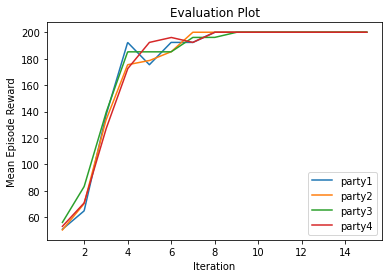

In [7]:
"""
#1 define a method to plot a smooth cure
"""
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

def smooth_curve(xaxis, yaxis):
   xnew = np.linspace(min(xaxis), max(xaxis), len(xaxis)*50) 

   spl = make_interp_spline(xaxis, yaxis, k=1)  # type: BSpline
   power_smooth = spl(xnew)
   return xnew, power_smooth 



"""
#2 plot the evaluation curve
"""
for i in range(num_parties):
    eval_party_xaxis, eval_party_yaxis = smooth_curve(iterations[i], eval_party_episode_reward_mean[i])
    line1, = plt.plot(eval_party_xaxis, eval_party_yaxis)
    line1.set_label('party'+str(i+1))
plt.title('Evaluation Plot')
plt.ylabel('Mean Episode Reward')
plt.xlabel('Iteration')
plt.legend()
plt.show()

We observe from the plots, that the **Mean Episode Reward** value reaches 200 and then stabilizes. 

## Shut Down
Invoke the `stop()` function on each of the network participants to terminate the service.

In [8]:
aggregator.stop()
for party in partyList:
    party.stop()

2020-10-06 03:25:10,136 -STD ibmfl.aggregator.protohandler.proto_handler - INFO - State: States.SND_REQ
2020-10-06 03:25:10,194 -STD ibmfl.connection.flask_connection - INFO - Request received for path :14
2020-10-06 03:25:10,196 -STD ibmfl.connection.flask_connection - INFO - Request received for path :14
2020-10-06 03:25:10,210 -STD ibmfl.party.party_protocol_handler - INFO - Received request from aggregator
2020-10-06 03:25:10,202 -STD ibmfl.party.party_protocol_handler - INFO - Received request from aggregator
2020-10-06 03:25:10,205 -STD ibmfl.connection.flask_connection - INFO - Request received for path :14
2020-10-06 03:25:10,235 -STD ibmfl.party.party_protocol_handler - INFO - Received request in with message_type:  14
2020-10-06 03:25:10,241 -STD ibmfl.party.party_protocol_handler - INFO - Received request from aggregator
2020-10-06 03:25:10,250 -STD ibmfl.party.party_protocol_handler - INFO - Received request in with message_type:  14
2020-10-06 03:25:10,236 -STD ibmfl.party